# Imports



In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
from glob import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model

#from itertools import chain

In [3]:
! pip freeze > requirements.txt

In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d nih-chest-xrays/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

---
# 1. Preprocessing Data

This section reads in the data and creates a dataframe of the paths and the labels to the images. Furthermore, the labels are split and one-hot encoded.

In [ ]:
# import data

all_xray_df = pd.read_csv('/content/drive/MyDrive/Data_Entry_2017.csv')

# obtain path to each image and add to dataframe
# use glob module to intelligently parse all files
# add to dictionary with key as filename
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/content/drive/MyDrive/NIH-XRay/', 'images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Rows', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)



# multiclass classification
# find nulls  
all_xray_df['Finding Labels']  = all_xray_df['Finding Labels'].replace('No Finding', '')
all_labels = list({x for l in all_xray_df['Finding Labels'].str.split('|') for x in l})

all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)> 1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df = all_xray_df.drop(['OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 
                               'Finding Labels',
                               'Follow-up #',
                               'OriginalImage[Width','Height]'
                               ], axis=1)

all_xray_df.sample(3)

Scans found: 112120 , Total Rows 112120
All Labels (14): ['Nodule', 'Cardiomegaly', 'Atelectasis', 'Pneumonia', 'Mass', 'Fibrosis', 'Edema', 'Consolidation', 'Hernia', 'Pleural_Thickening', 'Pneumothorax', 'Emphysema', 'Infiltration', 'Effusion']


,Image Index,Patient ID,Patient Age,Patient Gender,View Position,path,Nodule,Cardiomegaly,Atelectasis,Pneumonia,Mass,Fibrosis,Edema,Consolidation,Hernia,Pleural_Thickening,Pneumothorax,Emphysema,Infiltration,Effusion
4465,00001206_006.png,1206,53,F,PA,/content/drive/MyDrive/NIH-XRay/images_001/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31231,00008141_000.png,8141,19,F,PA,/content/drive/MyDrive/NIH-XRay/images_004/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107951,00029200_000.png,29200,59,M,PA,/content/drive/MyDrive/NIH-XRay/images_012/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Number of unique patients:' , all_xray_df['Patient ID'].nunique())


Number of unique patients: 30805


In [ ]:
#sns.distplot(all_xray_df['Patient Age'])
idx = all_xray_df['Patient Age'].sort_values().index[-2]
plt.imshow(plt.imread(all_xray_df.iloc[idx]['path']), cmap='bone')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


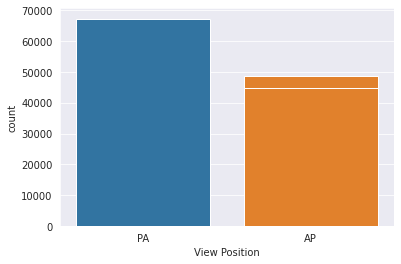

In [ ]:
sns.countplot(all_xray_df['Patient Gender'])
sns.countplot(all_xray_df['View Position'])

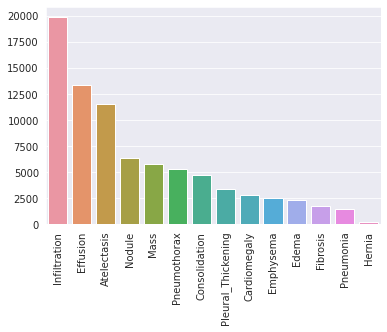

In [ ]:
#sns.countplot()
sns.barplot(x=all_labels, 
            y=all_xray_df[all_labels].sum(), 
            order = all_xray_df[all_labels].sum().sort_values(ascending=False).index)

plt.tick_params(axis='x', rotation=90)

# 2. Preparing data 

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

n = None # use all data
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

for train_idx, test_idx in gss.split(all_xray_df[: n], groups = all_xray_df[: n]['Patient ID'].values):
    train_df = all_xray_df.iloc[train_idx]
    test_df, valid_df = train_test_split(all_xray_df.iloc[test_idx], 
                                   test_size = 0.5, 
                                   random_state = 42) #should add stratified sampling
    
train_df.head()
test_df.head()

,Image Index,Patient ID,Patient Age,Patient Gender,View Position,path,Nodule,Cardiomegaly,Atelectasis,Pneumonia,Mass,Fibrosis,Edema,Consolidation,Hernia,Pleural_Thickening,Pneumothorax,Emphysema,Infiltration,Effusion
53848,00013594_029.png,13594,46,M,AP,/content/drive/MyDrive/NIH-XRay/images_006/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13979,00003610_010.png,3610,30,F,PA,/content/drive/MyDrive/NIH-XRay/images_002/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
91299,00022776_005.png,22776,59,F,AP,/content/drive/MyDrive/NIH-XRay/images_010/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4377,00001193_000.png,1193,52,F,PA,/content/drive/MyDrive/NIH-XRay/images_001/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73092,00018006_009.png,18006,60,M,AP,/content/drive/MyDrive/NIH-XRay/images_008/ima...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=32, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=32, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
IMAGE_DIR = None # our column contains the absolute paths
train_generator = get_train_generator(train_df, IMAGE_DIR, "path", all_labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "path", all_labels)

getting train generator...
Found 78566 validated image filenames.
getting train and valid generators...
Found 78566 validated image filenames.
Found 16777 validated image filenames.
Found 16777 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


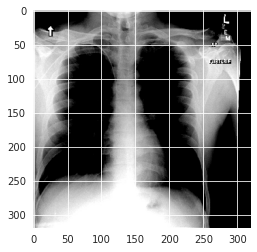

In [ ]:
# show example
x, y = train_generator.__getitem__(2)
plt.imshow(x[0]);

We use the weighted loss function to account for class imbalance.

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = len(labels)
    
    positive_frequencies = (np.sum(labels, 0)) / N
    negative_frequencies = (1- positive_frequencies)

    return positive_frequencies, negative_frequencies



def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -1 * K.mean(pos_weights * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg_weights * K.log(1 - y_pred + epsilon))
            
        return loss
    
    return weighted_loss

freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights



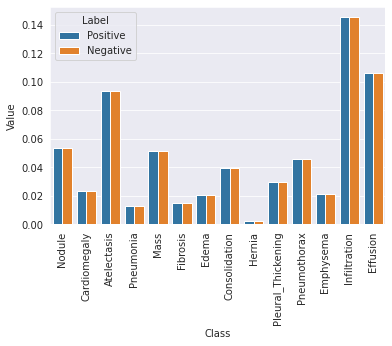

In [ ]:
data = pd.DataFrame({"Class": all_labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": all_labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

# 3. Training the model


In [ ]:
import tensorflow as tf

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
)
# base_model = tf.keras.applications.DenseNet169(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
# )

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(all_labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

checkpoint_path = '/content/drive/MyDrive/xray_class_weights_densenet121_v1.best.hdf5'
#model.load_weights(checkpoint_path)
#model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
#weight_path="./{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks_list = [checkpoint, early, reduce_lr]


history = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = 100,
                    validation_steps = 10,
                    epochs = 2,
                   callbacks = callbacks_list)

Epoch 1/2
 70/100 [====================>.........] - ETA: 8:01 - loss: 0.9079

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/xray_classifier_densenet121_model_v1.h5')

In [ ]:
pred_Y = model.predict(test_generator, batch_size = 32, verbose = True)

525/525 [==============================] - 4902s 9s/step


Text(0, 0.5, 'True Positive Rate')

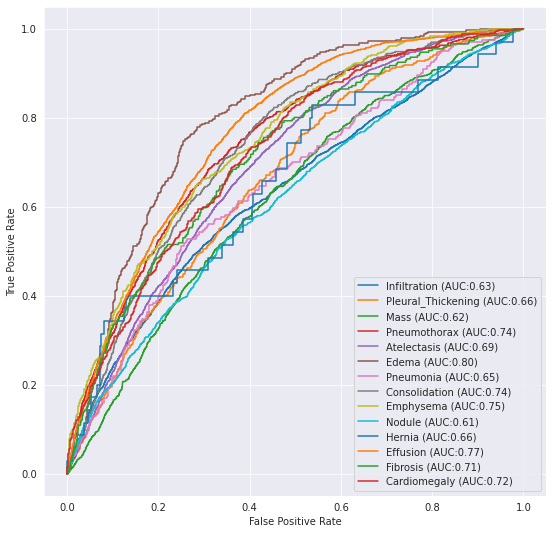

In [ ]:
from sklearn.metrics import roc_curve, auc

test_Y = test_generator.labels
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

Evaluation metrics are a bit lower than the CheXNet paper published, can the model be trained in a better way?

In [ ]:
predY_df = pd.DataFrame(predY)
predY_df.to_csv("/content/drive/MyDrive/xray_class_weights_densenet121_pred_v1.csv")

# Load model from a save point

In [ ]:
checkpoint_path = '/content/drive/MyDrive/xray_class_weights_densenet121_v1.best.hdf5'

In [ ]:
reconstructed_model = tf.keras.models.load_model(checkpoint_path)